In [ ]:
# mice pose estimation
# coded in colab

import os
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [ ]:
!git clone https://github.com/hongh-zhang/Vision.git
path = 'Vision/mice/'

Cloning into 'Vision'...
remote: Enumerating objects: 343, done.
remote: Counting objects: 100% (343/343), done.
remote: Compressing objects: 100% (325/325), done.
remote: Total 343 (delta 29), reused 319 (delta 13), pack-reused 0
Receiving objects: 100% (343/343), 45.92 MiB | 12.81 MiB/s, done.
Resolving deltas: 100% (29/29), done.


# preprocess

In [ ]:
# reading & preprocessing training data

# images are read as numpy array (/tensorflow tensors) by opencv automatically

# keypoint locations are provided in a csv file as (x,y) coordinates
# so we'll have to convert it into array/tensors
# each body part coordinate & surrounding pixels are valued as 1.0
# the rest(background) being 0 to produce a heatmap for each body part
# examples below

RADIUS = 3  # influence range of each label
SHAPE = (240, 320)  # shape of label


images = []
labels = []

for img_file, row in zip(sorted(os.listdir(path+'data/frames')), 
            pd.read_csv(path+'data/CollectedData_Pranav.csv').iloc[2:,1:].to_numpy(dtype=float)):
    
    # read image into (1, 480, 640, 3) tesnor
    img = cv2.imread(os.path.join(path+'data/frames',img_file))
    img = tf.convert_to_tensor(img.reshape(1, 480, 640, 3), dtype=float)/255.0
    
    # process label coordinate into heatmap
    lbl = []
    for i in range(0, 8, 2):

        # read coordinates
        # downsample by 2 to reduce operations
        x = round(row[i] / 2)
        y = round(row[i+1] / 2)
        
        # create heatmap from coordinates
        heatmap = cv2.circle(np.zeros(SHAPE), (x, y), RADIUS, 255, -1) / 255.0
        heatmap = tf.reshape(tf.convert_to_tensor(heatmap, dtype=float), (1, 240, 320, 1))
        lbl.append(heatmap)
    # combine into a single tensor & normalize to 0-1
    lbl = tf.concat(lbl, axis=3)  # each lbl: (1, 240, 320, 4)
    
    images.append(img)
    labels.append(lbl)

    # flip
    for axis in ([1],[2],[1,2]):
        new_img = tf.reverse(img, axis)
        new_lbl = tf.reverse(lbl, axis)
        images.append(new_img)
        labels.append(new_lbl)

# convert list of tensors into a large tensor
images = tf.concat(images, axis=0)
labels = tf.concat(labels, axis=0)

# cast labels into 1+4d, -> (None, 240, 320, 4, 2)
labels = tf.stack([1-labels, labels], axis=4)
print(labels.shape)
# each dim corresponds to
# (batch size, height, width,
# no. of feature, we have (snout, L.ear, R.ear, tail) here,
# probability of feature/non-feature)

# the last dimension is actually redundant, but required to work with
# tensorflow's categorical cross entropy loss
# (didn't manage to properly use the binary cross entropy loss, maybe
# a custom loss is required?)

(464, 240, 320, 4, 2)


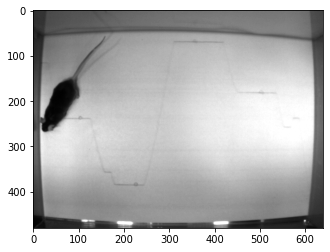

In [ ]:
# sample image
plt.imshow(images[0].numpy()[:,:,0], cmap='gray');

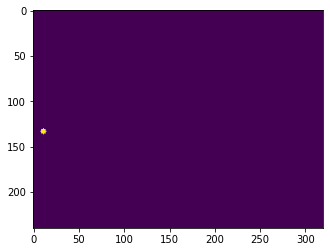

In [ ]:
# sample label for snout position
# (half the size)
plt.imshow(labels[0].numpy()[:,:,0,1] * 255);
# basically a binary classification task on all pixels

In [ ]:
# spliting validation set
test_images = images[:20]
test_labels = labels[:20]
images = images[20:]
labels = labels[20:]

# Train

In [ ]:
class Model(tf.keras.Model):
    def __init__(self,):
        super().__init__(self)

        # low dropout for augmentation
        self.dropout = layers.Dropout(0.1)

        # using pre-trained resNet50 to extract features
        self.resNet = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                weights='imagenet', input_shape=(480, 640, 3), pooling=None)

        # upsampling layers
        self.up = tf.keras.Sequential([
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(1024, 3, padding='same', activation='ReLU'),
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(512, 3, padding='same', activation=None),
            layers.BatchNormalization(),
            layers.Activation('relu'),

            layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(256, 3, padding='same', activation='ReLU'),
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(128, 3, padding='same', activation=None),
            layers.BatchNormalization(),
            layers.Activation('relu'),
        ])

        # output layers
        self.out = tf.keras.Sequential([
            layers.Conv2D(64, 3, padding='same', activation='ReLU'),
            layers.Conv2D(4, 1, padding='same', activation=None)
        ])
        self.activate = layers.Activation('softmax')

    def call(self, X, training=False):

        # augmentation
        #X = self.dropout(X, training=training)
        
        # save for later concat
        X0 = tf.nn.max_pool(X, ksize=2, strides=2, padding="VALID")

        # extract features with resNet, then upsample to 320*240
        X = self.resNet(X)
        X = self.up(X, training=training)

        # concat high resolution map onto feature map
        X = tf.concat([X0, X], axis=3)
        X = self.out(X)
        # shape: (None, 240, 320, 4)

        # rearrange into binary probability format
        X = tf.stack([1-X, X], axis=4)
        # shape: (None, 240, 320, 4, 2)

        X = self.activate(X)
        return X

In [ ]:
gc.collect();

nn = Model()
print(nn(test_images[0:1]).shape)
nn.summary()

94781440/94765736 [==============================] - 2s 0us/step
(1, 240, 320, 4, 2)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 resnet50 (Functional)       (None, 15, 20, 2048)      23587712  
                                                                 
 sequential (Sequential)     (1, 240, 320, 128)        25072000  
                                                                 
 sequential_1 (Sequential)   (1, 240, 320, 4)          75780     
                                                                 
 activation_2 (Activation)   multiple                  0         
                                                                 
Total params: 48,735,492
Trainable params: 48,681,092
Non-trainable params: 54,400
_________________________

In [ ]:
nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4, name='Adam'), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    )
nn.fit(x=images, y=labels, shuffle=True, batch_size=4, epochs=40, 
       verbose='auto', validation_data=(test_images, test_labels));
# larger batch size breaks colab

In [ ]:
plt.imshow(nn(test_images[0:1])[0,:,:,0,1].numpy() * 255)

In [ ]:
plt.imshow(test_labels[0:1][0,:,:,0,1].numpy() * 255)

In [ ]:
# save model
nn.save_weights('./checkpoints/my_checkpoint')
!zip -r checkpoint.zip checkpoints

# Label

In [ ]:
# download my trained model
!gdown --id 1voRs2GUjfCOZpiKbJOtB5FXrOBGeHnDI
!unzip checkpoint.zip

Downloading...
From: https://drive.google.com/uc?id=1voRs2GUjfCOZpiKbJOtB5FXrOBGeHnDI
To: /content/checkpoint.zip
100% 549M/549M [00:02<00:00, 223MB/s]


In [ ]:
nn = Model()
nn(np.zeros((1,480,640,3)));
nn.load_weights('checkpoints/my_checkpoint');

In [ ]:
class Converter():
    """Convert heatmap into coordinate for labelling"""
    
    def __init__(self, shape, scale):
        
        self.shape = shape  # matrix shape of predicted labels
        self.scale = scale  # scale relative to raw input image
        
        # initialization for mean converter
        # create matrix with each cell valued at its row/col number
        xs = np.arange(shape[1]) + 1
        ys = np.arange(shape[0]) + 1
        self.xs = np.repeat(xs, shape[0]).reshape(shape[::-1]).T
        self.ys = np.repeat(ys, shape[1]).reshape(shape)
        
    # mean
    # does not work ATM due to unexpected noise in output
    # but should be more accurate when noise is properly handled
    def convert(self, pred):
        return (np.sum(self.xs*pred) / np.sum(pred) * self.scale,
                np.sum(self.ys*pred) / np.sum(pred) * self.scale)
    
    # mode (argmax)
    def convert2(self, pred):
        y = np.unravel_index(pred.argmax(), self.shape)
        return y[0]*2, y[1]*2
    
    def __call__(self, *args, **kwargs):
        return self.convert2(*args, **kwargs)
    
conv = Converter((240, 320), 2)
conv(nn(test_images[0:1])[0,:,:,0,1].numpy())

(266, 24)

In [ ]:
frames = []
cap = cv2.VideoCapture(path+'data/video.mp4')
while(cap.isOpened()):
    ret, frame0 = cap.read()
    if ret:
        frames.append(frame0)
    else:
        break
        
cap.release()
cv2.destroyAllWindows()

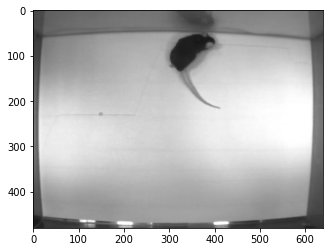

In [ ]:
frame = frames[99]
plt.imshow(frame);

198.0 32.0


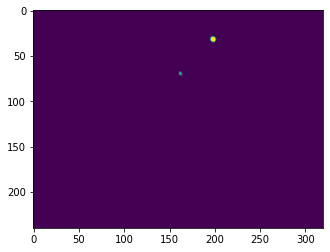

In [ ]:
plt.imshow(nn(frame.reshape(1, 480, 640, 3) / 255.0)[0,:,:,0,1].numpy()*255);
coord = conv(nn(frame.reshape(1, 480, 640, 3) / 255.0)[0,:,:,0,1].numpy())
print(coord[1]/2, coord[0]/2)

# TODO:
# reduce noise...
# then try using mean converter

In [ ]:
# generating prediction heatmaps to take a peek on training results

# somehow i cant get cv2 to create grayscale video
# out = cv2.VideoWriter('out.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (240, 320), 0)

for f in frames:
    f_out = (nn(f.reshape(1, 480, 640, 3) / 255.0)[0,:,:,0,1]*255).numpy().astype(np.uint8)
    cv2.imwrite('outputs/{i}.jpg', f_out)
    # out.write(f_out)

# out.release()


!zip -r outputs.zip outputs

In [ ]:
cap = cv2.VideoCapture('Vision/mice/data/video.mp4')
out = cv2.VideoWriter('out.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (int(cap.get(3)),int(cap.get(4))))

while(cap.isOpened()):
    ret, frame0 = cap.read()
    if ret:
        
        # format & pass into CNN
        frame = frame0.reshape(1, 480, 640, 3) / 255.0
        output = nn(frame)
        
        # compute coordinates
        coord_s = conv(output[0,:,:,0,1].numpy())
        coord_r = conv(output[0,:,:,1,1].numpy())
        coord_l = conv(output[0,:,:,2,1].numpy())
        coord_t = conv(output[0,:,:,3,1].numpy())
        
        # write to frame
        frame = cv2.circle(frame0, (round(coord_s[1]), round(coord_s[0])), 3, (200,0,0), -1)
        frame = cv2.circle(frame, (round(coord_r[1]), round(coord_r[0])), 3, (200,0,200), -1)
        frame = cv2.circle(frame, (round(coord_l[1]), round(coord_l[0])), 3, (0,0,200), -1)
        frame = cv2.circle(frame, (round(coord_t[1]), round(coord_t[0])), 3, (0,200,0), -1)
        
        out.write(frame)
        
    else:
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()